In [1]:
import numpy as np
import random
from data import Synthesize

PERIOD_LENGTH = 6 # numero de horas de cada periodo
N_PERIODS_YEAR = int((24/PERIOD_LENGTH) * 365) # numero de periodos per year

# conjuntos
sources = ['solar', 'wind', 'hydroelectric', 'nuclear', 'gas', 'coal', 'oil'] # conjunto _i
periods = [i for i in range(1, N_PERIODS_YEAR+1)] # conjunto _t

# parametros constantes
P = 700000000000 # presupuesto en dolares 

pi = 40 # cantidad de anos en los que se espera recuperar la inversion inicial

D_t = Synthesize().synthesize_data(N_PERIODS_YEAR) # diccionario tipo {periodo:demanda}

AC = 103240 # costo por bateria en dolares AC
AQ = 232 # capacidad de almacenamiento en kWh por bateria AQ
AE = 0.87 # eficiencia de energia de las baterias AE
AZ = 46400 # kgs de CO2 emitidos por bateria producida AZ

S = 0.1 # valor por kWh en el mercado promedio en dolares

# parametro CI_i costo inicial por kW de capacidad en dolares
overnight_cost = {
    'solar': [1331, 1313, 1100],
    'wind': [1100, 1500, 1319],
    'hydroelectric': [5316, 1750, 7500, 3500],
    'nuclear': [6041, 6317, 6900, 12000],
    'gas': [950, 713, 1084],
    'coal': [3000, 6250, 5876, 3676],
    'oil': [1170, 1175, 713],
    }

# modelaremos ocupando la media en casos donde hayan mas de un dato
CI_i = {
    key:np.mean(value) for key, value in  zip(overnight_cost.keys(), 
                                              overnight_cost.values())
}
    
# parametro C_i costo de produccion por kWh en dolares
production_cost = {
    'solar': [0.0017, 0.00136],
    'wind': [0.003, 0.0032],
    'hydroelectric': [0.005],
    'nuclear': [0.0210, 0.0138, 0.016],
    'gas': [0.021],
    'coal': [0.0098, 0.014, 0.0173],
    'oil': [0.054, 0.0701, 0.0563],
}

# al igual que el costo inicial, ocuparemos la media
C_i = {
    key:np.mean(value) for key, value in zip(production_cost.keys(),
                                            production_cost.values())
}

# kg de CO2 emitidos por producir un kWh Z_i
Z_i = {
    'solar': 0.085,
    'wind': 0.026,
    'hydroelectric': 0.026,
    'nuclear': 0.029,
    'gas': 0.499,
    'coal': 0.888,
    'oil': 0.733,
    }

# to-do: cantidad maxima disponible para instalaciones QM_i
# prod_units_limit = {source:limit for source, 
#                     limit in zip(sources, np.array([random.randint(9448046//6, 267628704//6) for _ in 
#                                                                                 range(len(sources))]))}

QM_i = {source:150000000 for source in sources}

In [2]:
# to-do: graficos de volumenes amontonados en una sola figura para los datos

### Explicacion de los datos:

La demanda la calculamos usando la demanda por hora durante un dia y la demanda por dia durante un 
año. Mezclando las variaciones entre ambos se hizo un conjunto con la demanda para cada periodo (con cada periodo de 6 horas la suma de la demanda en esas horas).

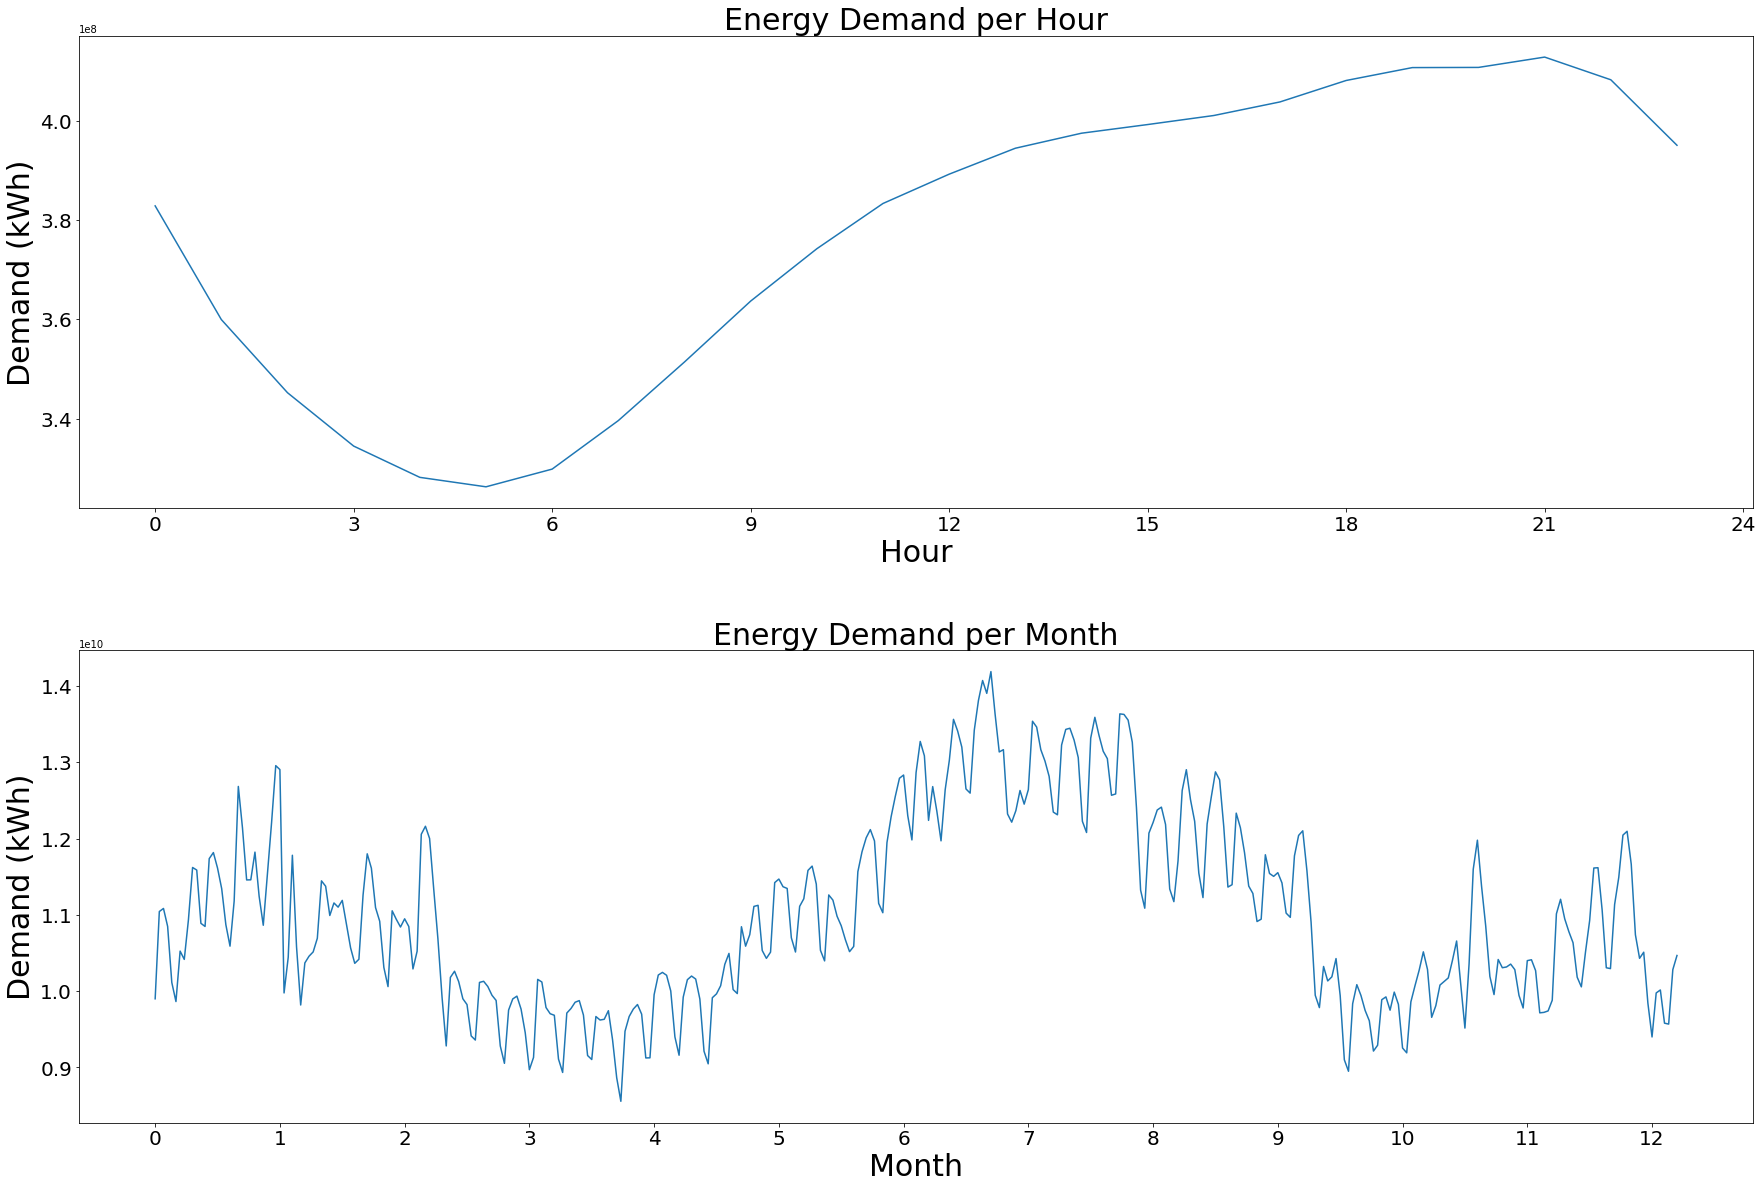

In [3]:
from matplotlib import pyplot as plt
from matplotlib.ticker import MultipleLocator, AutoMinorLocator

hourly = Synthesize().read_data(Synthesize().hourly)
# usamos un solo dia ocupando los promedios del mes para ver la variacion segun la hora
hourly = [np.mean(v) for v in hourly.values()]

daily = Synthesize().read_data(Synthesize().daily)
daily_y = []
for month in daily:
    daily_y.extend(daily[month])
    
    
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(30, 20))

ax1.set_title('Energy Demand per Hour', fontsize=30)
ax2.set_title('Energy Demand per Month', fontsize=30)


ax1.set_xlabel('Hour', fontsize=30)
ax1.set_ylabel('Demand (kWh)', fontsize=30)

ax2.set_xlabel('Month', fontsize=30)
ax2.set_ylabel('Demand (kWh)', fontsize=30)

ax1.xaxis.set_major_locator(MultipleLocator(3))
ax1.tick_params(axis='both', which='major', labelsize='20')

ax2.xaxis.set_major_locator(MultipleLocator(30))
ax2.set_xticklabels([i for i in range(-1, 13)]) # por alguna razon si empieza en 0 el range, el grafico parte en 1
ax2.tick_params(axis='both', which='major', labelsize='20')


plt.subplots_adjust(hspace=0.3)

ax1.plot(hourly)
ax2.plot(daily_y)


**Usando estos datos se calculo la demanda para cada periodo**:

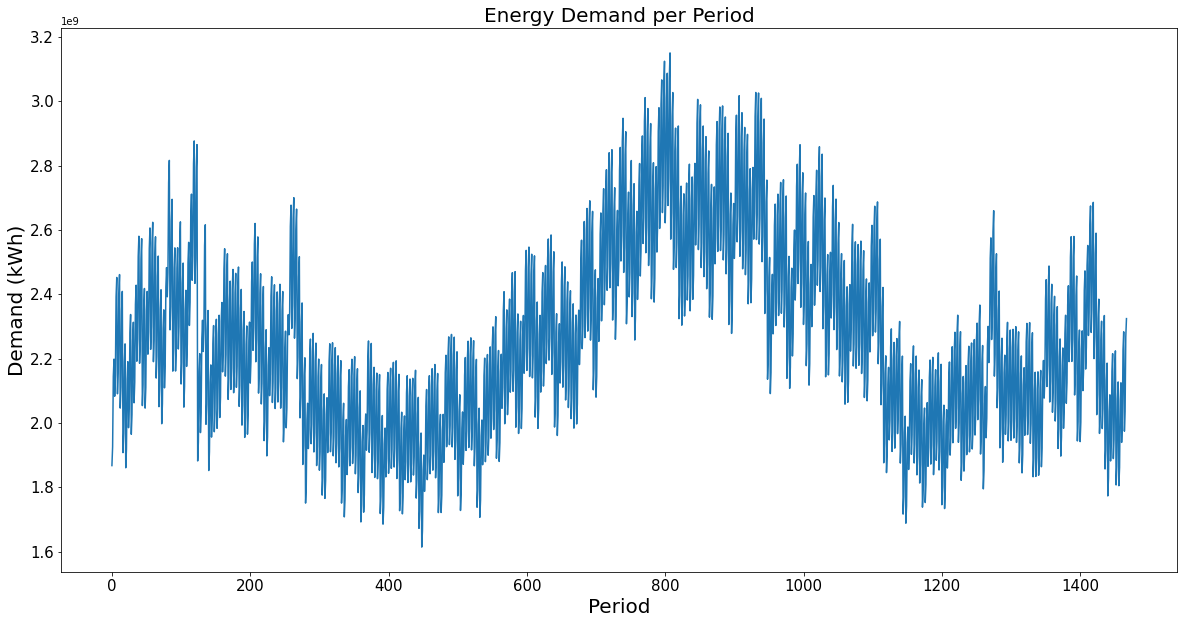

In [4]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.set_title('Energy Demand per Period', fontsize=20)


ax.set_xlabel('Period', fontsize=20)
ax.set_ylabel('Demand (kWh)', fontsize=20)

ax.xaxis.set_major_locator(MultipleLocator(200))
ax.tick_params(axis='both', which='major', labelsize='15')
                       
ax.plot([i for i in D_t.values()])

*Como podemos ver la demanda tiene una variacion similar a lo largo del año comparando con los datos recolectados, y si escogemos algun periodo mas acotado al azar:*

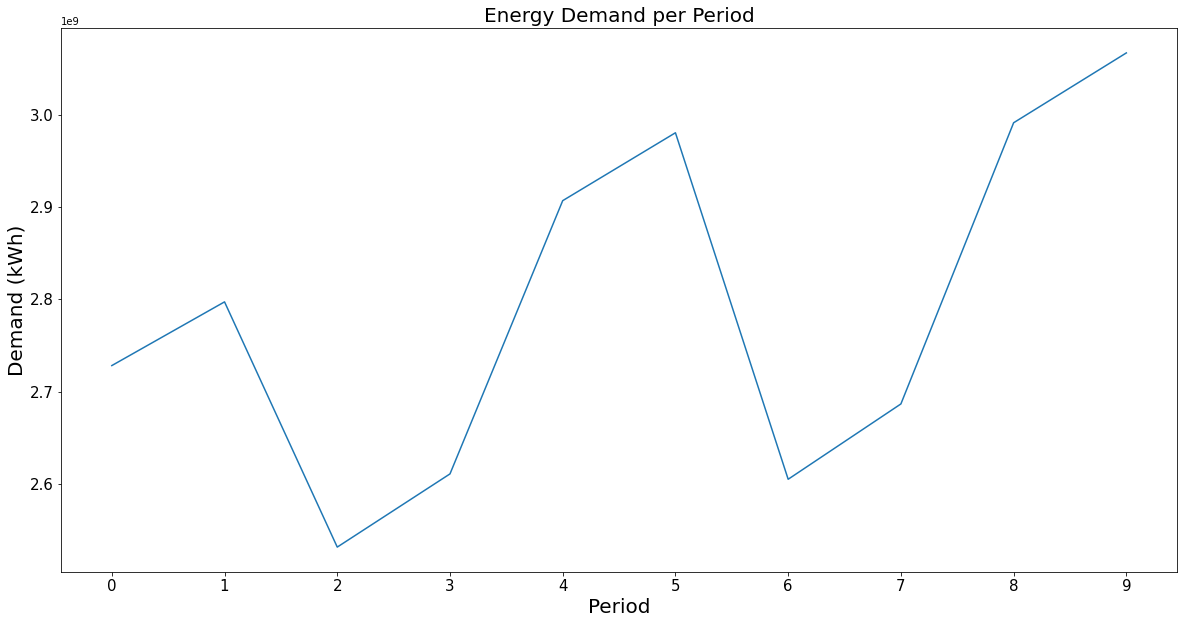

In [5]:
from random import randint
rndm = randint(0, 1460)
random_days = [i for i in D_t.values()][rndm:rndm+10]

fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.set_title('Energy Demand per Period', fontsize=20)


ax.set_xlabel('Period', fontsize=20)
ax.set_ylabel('Demand (kWh)', fontsize=20)

ax.xaxis.set_major_locator(MultipleLocator(1))
ax.tick_params(axis='both', which='major', labelsize='15')


ax.plot(random_days)

*Podemos ver como cambia a lo largo del dia (4 periodos) la demanda energetica.*

# Ahora modelamos:

In [6]:
from gurobipy import GRB, Model, quicksum

model = Model('Energy production planning')

xi_i = model.addVars(sources, vtype=GRB.INTEGER, name='prod_units')
a = model.addVar(vtype=GRB.INTEGER, name='storage')
x_it = model.addVars(periods, sources, vtype=GRB.CONTINUOUS, name='output')
b_t = model.addVars(periods, vtype=GRB.CONTINUOUS, name='stored')

model.update()

Using license file /home/rieg/gurobi.lic
Academic license - for non-commercial use only


In [7]:
initial_investment = quicksum(xi_i[source] * CI_i[source] 
                        for source in sources) + a * AC

# restriccion 1: inversion inicial menor o igual a presupuesto
model.addConstr(initial_investment <= P, name='budget_limit')

# restriccion 2: recuperacion de inversion (el presupuesto dividido en la cantidad de anos nos indica
# cuanto debemos recuperar cada ano)
profit = quicksum(x_it[period, source] * (S - C_i[source])
                     for source in sources for period in periods)

model.addConstr((profit >= (initial_investment/pi)), name='payback')

# restriccion 3: satisfaccion de demanda y flujo
model.addConstrs((b_t[period] == quicksum(x_it[period, source] for source in sources) - D_t[str(period)] + 
                                            (b_t[period - 1] * AE) 
                                                for idx, period in enumerate(periods) if idx != 0),
                                                                                     name='demand_meet')



# restriccion 4: produccion de energia limitada
model.addConstrs((x_it[period, source] <= xi_i[source] * PERIOD_LENGTH for source in sources
                                                                                for period in periods), 
                                                                                 name='energy_limit')
# restriccion 5: construccion de kw de capacidad limitadas 
model.addConstrs((xi_i[source] <= QM_i[source] for source in sources), name='prod_limit')

# restriccion 6: cantidad maxima de almacenamiento
model.addConstrs((b_t[period] <= a * AQ for period in periods), name='storage_limit')

# Naturaleza de las variables
# restriccion 7:
model.addConstrs((x_it[period, source] >= 0 for source in sources for period in periods), name='v_nature_7')
# restriccion 8:
model.addConstrs((xi_i[source] >= 0 for source in sources), name='v_nature_8')
# restriccion 9:
model.addConstr(a >= 0, name='v_nature_9')
# restriccion 10 y 11:
model.addConstrs((b_t[period] >= 0 for idx, period in enumerate(periods) if idx != 0), name='v_nature_10')
model.addConstrs((b_t[period] == 0 for idx, period in enumerate(periods) if idx == 0), name='v_nature_11')

{(0, 1): <gurobi.Constr *Awaiting Model Update*>}

In [8]:
obj = quicksum(x_it[period, source] * Z_i[source]\
               for source in sources for period in periods) + a * AZ

In [9]:
model.setObjective(obj, GRB.MINIMIZE)

model.optimize()
print('\n---------------------\n')

with open('gurobi_files/slack.text', 'w') as file:
    for constr in model.getConstrs():
        file.writelines(f"{constr}: {constr.getAttr('slack')}\n")
    file.close()
    
model.write('gurobi_files/model.sol')

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (linux64)
Optimize a model with 24836 rows, 11688 columns and 58422 nonzeros
Model fingerprint: 0x607c2a57
Variable types: 11680 continuous, 8 integer (0 binary)
Coefficient statistics:
  Matrix range     [4e-02, 1e+05]
  Objective range  [3e-02, 5e+04]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+08, 7e+11]
         Consider reformulating model or setting NumericFocus parameter
         to avoid numerical issues.
Presolve removed 11696 rows and 1 columns
Presolve time: 0.02s
Presolved: 13140 rows, 11687 columns, 46724 nonzeros
Variable types: 11679 continuous, 8 integer (0 binary)

Root relaxation: objective 3.739071e+11, 11320 iterations, 0.90 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3.7391e+11    0    2          - 3.7391e+11      -     -    0s
     0     0 3.7391e+11    0    2          - 3.7391e

In [10]:
if model.status == GRB.INFEASIBLE:
    model.computeIIS()
    model.write('gurobi_files/model.ilp')

# Analisis de los resultados:

**Cuanta capacidad decidió instalar el modelo por fuente de energia?**

<BarContainer object of 8 artists>

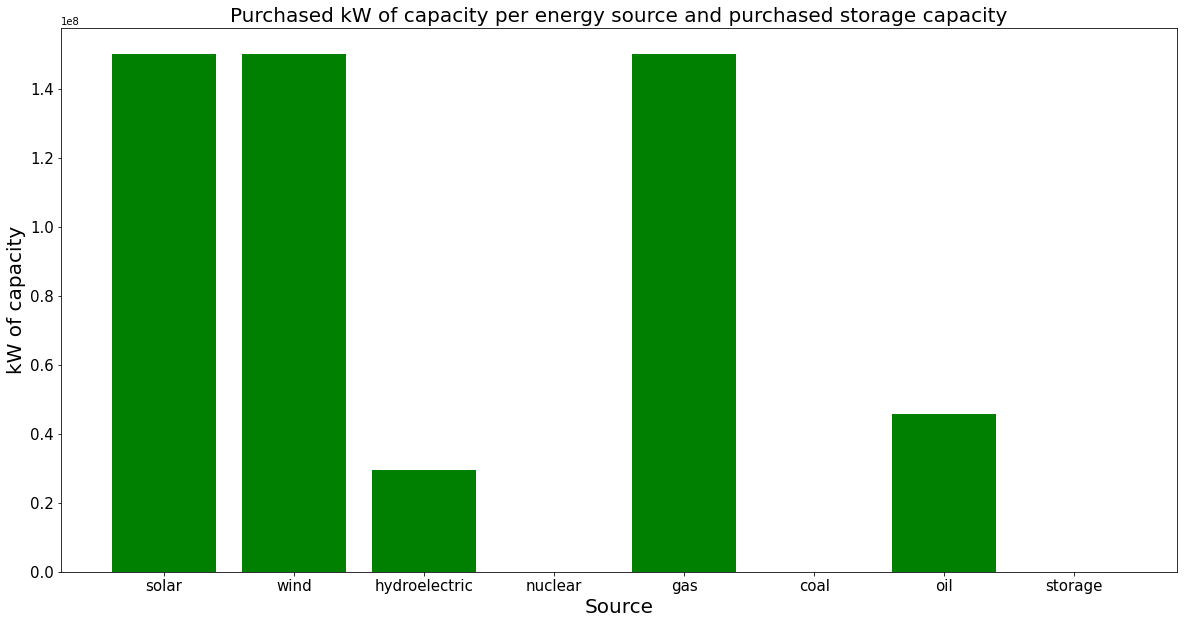

In [11]:
import re
import matplotlib.pyplot as plt

vars = model.getVars()

sources_prod_units = []
values_prod_units = []
for var in vars:
    if var.varName.startswith('prod_units'):
        source = re.search('\[([^$]*)]', var.varName).group(1)
        sources_prod_units.append(source)
        values_prod_units.append(var.x)
    elif var.varName == 'storage':
        sources_prod_units.append('storage')
        values_prod_units.append(var.x)
        
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.set_title('Purchased kW of capacity per energy source and purchased storage capacity', fontsize=20)

ax.set_xlabel('Source', fontsize=20)
ax.set_ylabel('kW of capacity', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize='15')

ax.bar(sources_prod_units, values_prod_units, color='green')

*Como podemos ver el modelo nos dijo que instalaramos lo maximo posible en energia solar, eólica y gas, y el resto lo repartió entre hidroelectrica y petroleo. Nada de energia nuclear, carbon ni baterias fueron necesarias.*

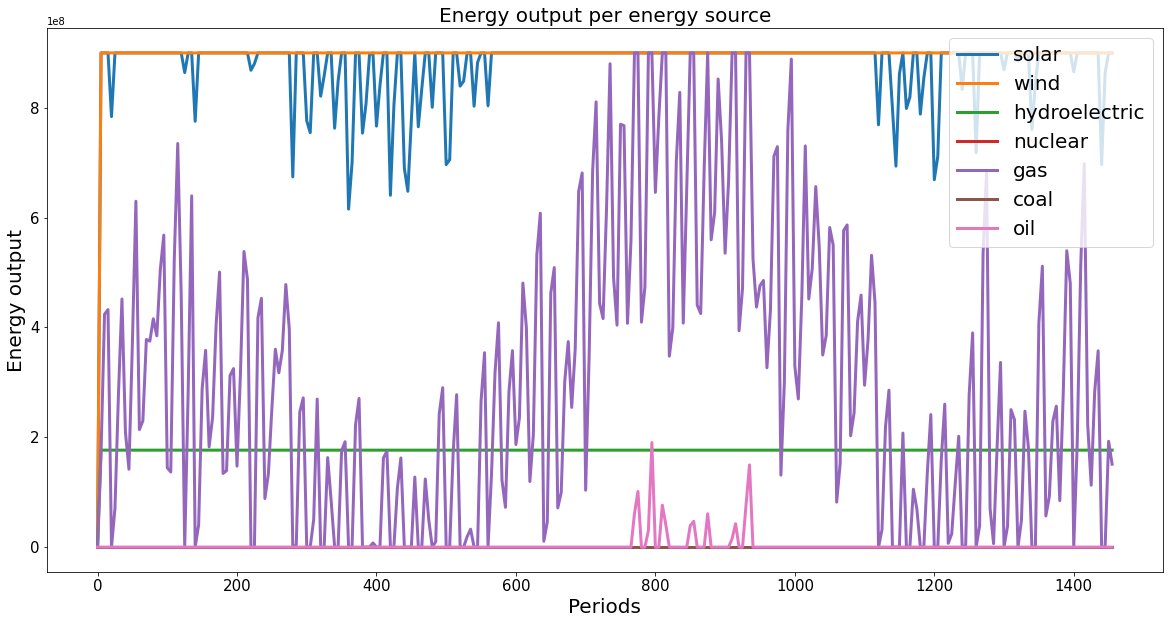

In [12]:
from collections import defaultdict

output = defaultdict(list)

for var in vars:
    if var.varName.startswith('output'):
        op = re.search('\[([^$]*)]', var.varName).group(1).split(',')
        source = op[1]
        period = op[0]
        energy = var.x
        output[source].append(energy)
      
fig, ax = plt.subplots(1, 1, figsize=(20, 10))

ax.set_title('Energy output per energy source', fontsize=20)

ax.set_xlabel('Periods', fontsize=20)
ax.set_ylabel('Energy output', fontsize=20)
ax.tick_params(axis='both', which='major', labelsize='15')
# ax.xaxis.set_major_locator(MultipleLocator(100))

for source in output:
    ax.plot([i for i in range(len(output[source]))][0::5], output[source][0::5], 
            linewidth=3, label=source)
        
    
ax.legend(loc='upper right', fontsize=20)

## Explicacion de los resultados:

**Energia solar**:
El modelo escogio producir el maximo de energia solar en casi todos los periodos, escepto en algunos donde se ve que la produccion esta cercana la limite.

**Energia eolica**:
El modelo escogio producir siempre el maximo de energia eolica, lo que hace sentido pues es de las mas baratas y es la que menos contamina.

**Energia hidroelectrica**:
El output de energia hidroelectrica es siempre el limite (recordar que el modelo escogio comprar menos capacidad para esta), lo que hace sentido pues el costo de produccion es super bajo (el mismo que solar, a diferencia de que esta contamina 1/3 de lo que contamina solar), por lo que una vez hecha la inversion conviene producir al limite

**Energia nucelar**:
El modelo escogio no comprar nada de capacidad de energia nuclear, por lo que obviamente no puede producir de esta. Las razones son probablemente que si bien contamina poco, tiene el costo inicial y de produccion mas alto.

**Gas**:
Este tipo de energia el modelo lo usa como alternativa cuando la demanda es muy alta, pues contamina bastante. Podemos ver que cuando la demanda no es tanta, y no es necesario producir el limite en energia solar, la produccion de esta energia es bajisima, demostrando la hipotesis.

**Carbon**:
Este tipo de energia dejo de ser economicamente superior y contamina demasiado, por lo que tiene sentido que el modelo no recurra a ella.

**Petroleo**:
El modelo escoge esta energia como ultima opcion cuando la demanda es altisima. El resto de los periodos intenta mantener la produccion en 0.